<a href="https://colab.research.google.com/github/Yufanzh/time_series_analysis/blob/main/RNN_Keras_example2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

## Data
Read in the data set "Miles_traveled.csv" from the Data folder. Figure out how to set the date to datatime index columns

In [4]:
df = pd.read_csv('./Miles_Traveled.csv', index_col = 'DATE', parse_dates=True)

In [5]:
df.head()

,TRFVOLUSM227NFWA
DATE,
1970-01-01,80173.0
1970-02-01,77442.0
1970-03-01,90223.0
1970-04-01,89956.0
1970-05-01,97972.0


In [10]:
df.columns = ['Values']

In [11]:
df.head()

,Values
DATE,
1970-01-01,80173.0
1970-02-01,77442.0
1970-03-01,90223.0
1970-04-01,89956.0
1970-05-01,97972.0


In [12]:
df.index.freq = 'MS'

## Plot out the time series and get the seasonal decompose

<Axes: title={'center': 'Miles Traveled'}, xlabel='DATE', ylabel='Miles'>

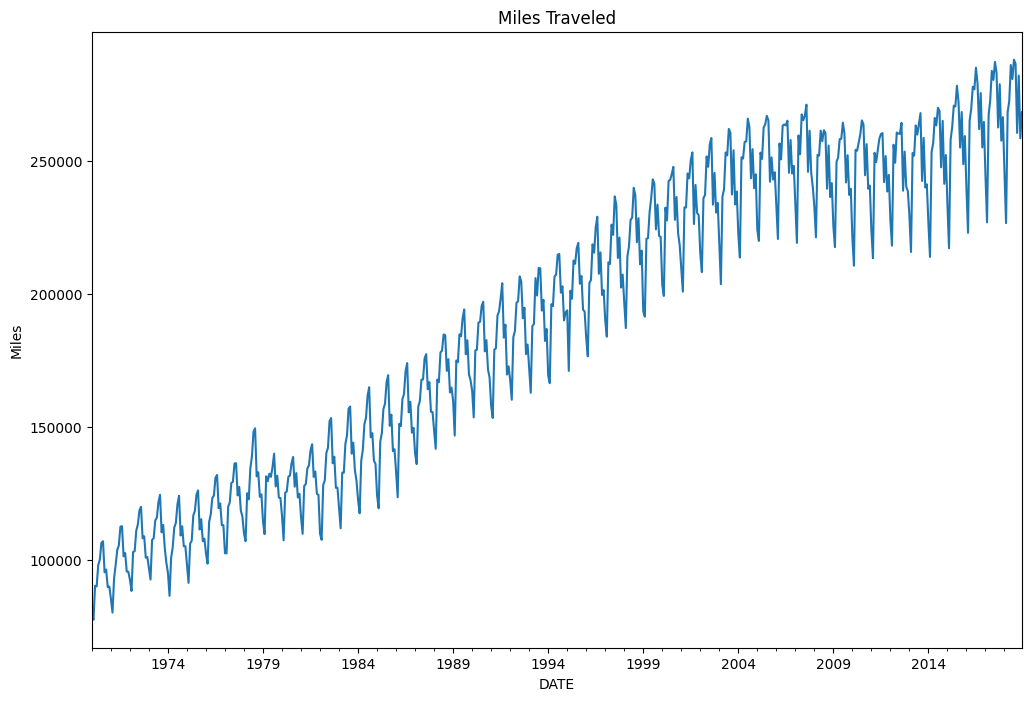

In [14]:
df['Values'].plot(figsize=(12,8), title='Miles Traveled', ylabel='Miles')

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [16]:
res = seasonal_decompose(df['Values'], model='add')

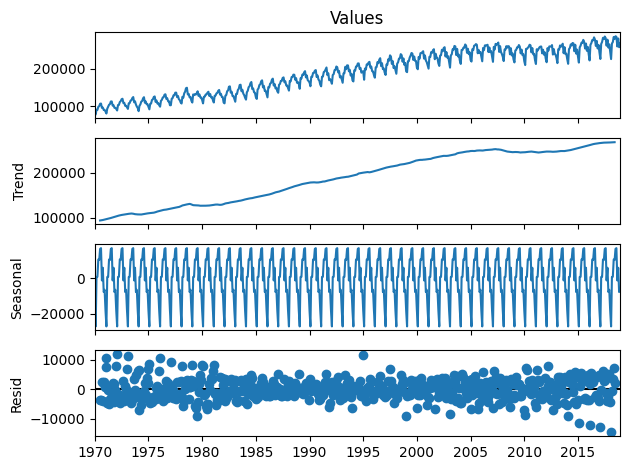

In [17]:
res.plot();

<Axes: xlabel='DATE'>

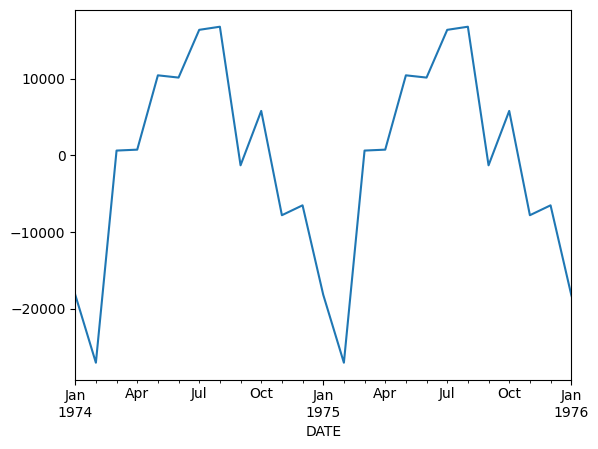

In [21]:
res.seasonal.plot(xlim=['1974-01-01', '1976-01-01'])

## Looks like a yearly seasonal
## Now Train Test Split and Scale data

In [22]:
len(df)

588

In [23]:
train = df.iloc[:-12]
test = df.iloc[-12:] # use 12 month for test

In [24]:
from sklearn.preprocessing import MinMaxScaler

In [26]:
scale = MinMaxScaler()
scale.fit(train)

MinMaxScaler()

In [27]:
scale_train = scale.transform(train)
scale_test = scale.transform(test)

## Create TimeseriesGenerator

In [29]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [31]:
n_input = 12
n_features = 1
generator = TimeseriesGenerator(scale_train, scale_train, length=n_input, batch_size = 1)

In [32]:
X, y = generator[0]

print(f'Given the array: \n {X.flatten()}')
print(f'Predict this y: \n {y}')


Given the array: 
 [0.0130109  0.         0.06089061 0.05961858 0.09780801 0.10763646
 0.13792216 0.14067108 0.08485905 0.08992334 0.05832273 0.0594042 ]
Predict this y: 
 [[0.03760821]]


## Creat the Model
similar as example1

In [35]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
import keras.backend as K

In [38]:
model = Sequential()
model.add(LSTM(150, activation='relu', input_shape = (n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [39]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 150)               91200     
                                                                 
 dense_1 (Dense)             (None, 1)                 151       
                                                                 
Total params: 91351 (356.84 KB)
Trainable params: 91351 (356.84 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Fit the model

In [40]:
model.fit(generator, epochs=30)

Epoch 1/30
564/564 [==============================] - 9s 13ms/step - loss: 0.0101
Epoch 2/30
564/564 [==============================] - 6s 11ms/step - loss: 0.0058
Epoch 3/30
564/564 [==============================] - 7s 13ms/step - loss: 0.0046
Epoch 4/30
564/564 [==============================] - 6s 11ms/step - loss: 0.0031
Epoch 5/30
564/564 [==============================] - 7s 13ms/step - loss: 0.0021
Epoch 6/30
564/564 [==============================] - 8s 13ms/step - loss: 0.0013
Epoch 7/30
564/564 [==============================] - 7s 12ms/step - loss: 0.0012
Epoch 8/30
564/564 [==============================] - 6s 11ms/step - loss: 0.0011
Epoch 9/30
564/564 [==============================] - 7s 13ms/step - loss: 9.7563e-04
Epoch 10/30
564/564 [==============================] - 8s 13ms/step - loss: 0.0010
Epoch 11/30
564/564 [==============================] - 7s 13ms/step - loss: 0.0011
Epoch 12/30
564/564 [==============================] - 6s 11ms/step - loss: 6.9345e-04
Epoch

Text(0, 0.5, 'loss')

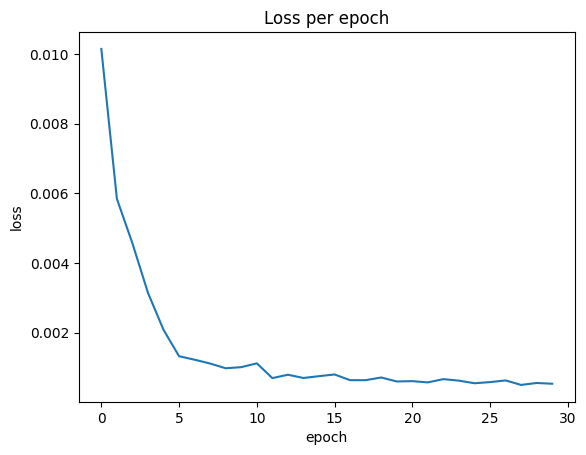

In [43]:
model.history.history.keys()
loss_per_epoch = model.history.history['loss']

plt.plot(range(len(loss_per_epoch)), loss_per_epoch)
plt.title('Loss per epoch')
plt.xlabel('epoch')
plt.ylabel('loss')

## Evaluate on the Test data

In [44]:
test_predicts = []
first_eval_batch = scale_train[-12:]
curr_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
  cur_predict = model.predict(curr_batch)[0]
  test_predicts.append(cur_predict)

  curr_batch = np.append(curr_batch[:,1:,:], [[cur_predict]], axis=1)

1/1 [==============================] - 0s 32ms/step


## Inverse Transformations and Compare

In [45]:
true_predicts = scale.inverse_transform(test_predicts)
true_predicts

array([[243199.28740364],
       [228753.61289299],
       [261689.92993587],
       [267577.70417118],
       [278107.68759352],
       [275676.99849808],
       [281615.60522926],
       [277557.93846703],
       [261222.59125739],
       [273205.62338823],
       [255717.54330343],
       [262270.63146079]])

In [46]:
test

,Values
DATE,
2018-01-01,245695.0
2018-02-01,226660.0
2018-03-01,268480.0
2018-04-01,272475.0
2018-05-01,286164.0
2018-06-01,280877.0
2018-07-01,288145.0
2018-08-01,286608.0
2018-09-01,260595.0


In [47]:
test['Predicts'] = true_predicts

<ipython-input-47-fa334d6ff142>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predicts'] = true_predicts


In [48]:
test

,Values,Predicts
DATE,,
2018-01-01,245695.0,243199.287404
2018-02-01,226660.0,228753.612893
2018-03-01,268480.0,261689.929936
2018-04-01,272475.0,267577.704171
2018-05-01,286164.0,278107.687594
2018-06-01,280877.0,275676.998498
2018-07-01,288145.0,281615.605229
2018-08-01,286608.0,277557.938467
2018-09-01,260595.0,261222.591257


<Axes: xlabel='DATE'>

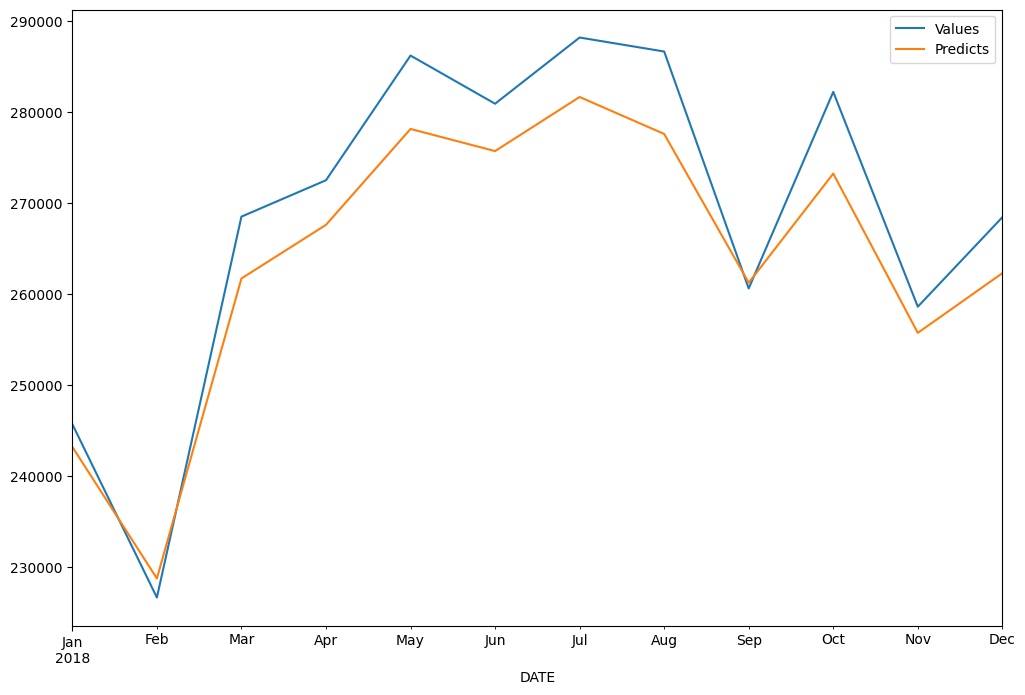

In [49]:
test.plot(figsize=(12,8))